In [1]:
import zmq
import msgpack
import sys
from pprint import pprint
import json
import numpy as np
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

port = "5556"

# SETUP

In [2]:
context = zmq.Context()
print "Connecting to server..."
socket = context.socket(zmq.REQ)
socket.connect ("tcp://localhost:%s" % port)

print "Sending request ", "ubuntu_cuda70","..."
socket.send ("ubuntu_cuda70")

message = socket.recv_json()
pprint(message)

optical_path = {}
for kk, vv in message.iteritems():
    print kk, ' is ', vv
    socket.send_string (vv)
    message = socket.recv_json()
    pprint(message)
    if kk=="Source":
        optical_path[vv] = ceo.JSource(message)
    elif kk=="GMT_MX":
        optical_path[vv] = ceo.JGMT_MX(message)
    elif kk=="Imaging":
         optical_path[vv] = ceo.JImaging(message)


Connecting to server...
Sending request  ubuntu_cuda70 ...
{u'GMT_MX': u'GMT', u'Imaging': u'imager', u'Source': u'star'}
Source  is  star
{u'N': 1,
 u'azimuth': [0.0],
 u'band': u'K',
 u'height': u'Inf',
 u'magnitude': 3,
 u'pupil sampling': 521,
 u'pupil size': 26.0,
 u'rays origin': [0, 0, 25],
 u'zenith': [0.0]}
GMT_MX  is  GMT
{u'M1': {u'Rxyz': False, u'Txyz': False, u'Zernike radial order': 3},
 u'M2': {u'Rxyz': False, u'Txyz': False, u'Zernike radial order': 0},
 u'pupil sampling': 521,
 u'pupil size': 26.0}
Imaging  is  imager
{u'guide star #': 1,
 u'nyquist factor': 2,
 u'pupil sampling': 521,
 u'resolution': 51}


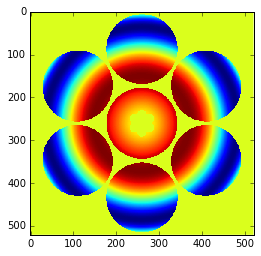

In [3]:
optical_path["star"].reset()
optical_path["GMT"].propagate(optical_path["star"])
optical_path["imager"].propagate(optical_path["star"])
plt.imshow(optical_path["star"].phase.host(),interpolation='None')

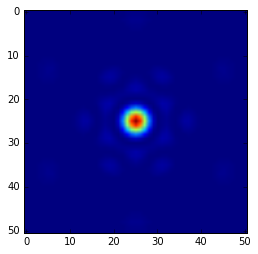

In [4]:
plt.imshow(optical_path["imager"].frame.host())

# DATA SERVER

In [5]:
data_port = "5557"
data_context = zmq.Context()
data_socket = data_context.socket(zmq.REP)
data_socket.bind("tcp://*:%s" % data_port)

In [8]:
message = data_socket.recv()
print "Received request: ", message

data_socket.send ("euler angles")
msg = data_socket.recv()
ea  = np.array( msgpack.unpackb(msg,use_list=False) )
print ea
optical_path["GMT"].M1.motion_CS.euler_angles[:] = ea
optical_path["GMT"].M1.motion_CS.update()

optical_path["star"].reset()
optical_path["GMT"].propagate(optical_path["star"])
optical_path["imager"].propagate(optical_path["star"])

data = optical_path["star"].phase.host()
msg = msgpack.packb(data.tolist())
data_socket.send(msg)

Received request:  wavefront
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.84813681e-06   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]
